# A NetCDF file

Here we investigate a NetCDF file. 

The file is available, 'Antarctic Sea Ice Thickness Estimates from CryoSat-2: 2010-2021' on Zenodo: https://zenodo.org/records/7327711, as comprises gridded estimates of Antarctic sea ice physical properties. 



In [39]:
import xarray
import matplotlib

In [40]:
ds = xarray.open_dataset("/vsicurl/https://zenodo.org/records/7327711/files/CS2WFA_25km_201007.nc?download=1", engine = "rasterio")

/workenv/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/workenv/lib/python3.12/site-packages/rioxarray/_io.py:1143: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore
/workenv/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/workenv/lib/python3.12/site-packages/rioxarray/_io.py:1143: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore
/wor

The file contains a number of variables, which include 'x' and 'y', 'spatial_ref', and 'lon', 'lat', among a number of 2D gridded datasets. As indicated by the warnings emitted by rasterio, there is nothing of use in x, y, or spatial_ref. 

In [44]:
print([v for v in ds.variables])

print(ds.spatial_ref)
print(ds.x.values)
print(ds.y.values)


['band', 'x', 'y', 'spatial_ref', 'density_ice_density', 'sea_ice_thickness_sea_ice_thickness_uncertainty', 'sea_ice_thickness_sea_ice_thickness_zero_icefreeboard', 'snow_depth', 'snow_freeboard', 'density_seawater_density', 'density_snow_density', 'ice_freeboard', 'lat', 'lon', 'sea_ice_concentration', 'sea_ice_thickness_sea_ice_thickness', 'sea_ice_thickness_sea_ice_thickness_70percent_threshold']
<xarray.DataArray 'spatial_ref' ()> Size: 8B
[1 values with dtype=int64]
Coordinates:
    spatial_ref  int64 8B ...
Attributes:
    GeoTransform:  0.0 1.0 0.0 0.0 0.0 1.0
[  0.5   1.5   2.5   3.5   4.5   5.5   6.5   7.5   8.5   9.5  10.5  11.5
  12.5  13.5  14.5  15.5  16.5  17.5  18.5  19.5  20.5  21.5  22.5  23.5
  24.5  25.5  26.5  27.5  28.5  29.5  30.5  31.5  32.5  33.5  34.5  35.5
  36.5  37.5  38.5  39.5  40.5  41.5  42.5  43.5  44.5  45.5  46.5  47.5
  48.5  49.5  50.5  51.5  52.5  53.5  54.5  55.5  56.5  57.5  58.5  59.5
  60.5  61.5  62.5  63.5  64.5  65.5  66.5  67.5  68.5  69.5 

Due to the lack of spatial referencing if we plot the image naively we get an unexpected view of Antarctic sea ice, the image is referenced only within its grid index, as indicated by the deafault transform (with offsets 0,0 and scale 1,1). Because the y-scale is positive the data presents in "upside down" view, which is a long held default for GDAL as used by rasterio. 

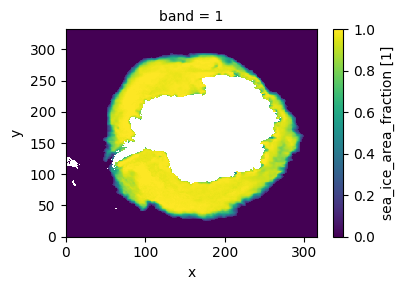

In [45]:
sic = ds.sea_ice_concentration
sic.plot.imshow(x = "x", y = "y", col = "band")

In the lon and lat arrays is recognizably useful information, which we could use with pcolormesh somehow. But we're going to take a guess and see what those look like as projected coordinates.

As a total guess, what if these lon,lat values were in south polar Stereographic projection?

In [85]:
import pyproj
import numpy
dim = (ds.lon.shape[1]* ds.lon.shape[2], 2)
dim



(104912, 2)

In [117]:
from pyproj import Transformer
def project_array(coordinates, target = 'EPSG:3412', source = 'EPSG:4326'):
    """
    Project a numpy (n,2) array in projection source to projection target
    Returns a numpy (n,2) array.
    Adpated from Uli Kohler https://stackoverflow.com/a/42459069
    """
    transformer = Transformer.from_crs(source, target, always_xy = True)
    fx, fy = transformer.transform(coordinates[:,0], coordinates[:,1])
    # Re-create (n,2) coordinates
    return numpy.dstack([fx, fy])[0]

In [134]:
## first we have to wrap the lon because pyproj doesn't apparently 
def lonwrap(lon0, lmin = -180): 
    return [((lon - lmin) % 360 + lmin) for lon in lon0]


ll = numpy.reshape([lonwrap(ds.lon.values), ds.lat.values], dim)
coords = project_array(ll)

numpy.reshape(coords[:, 1], ds.lon.shape[1:3]).shape

(332, 316)

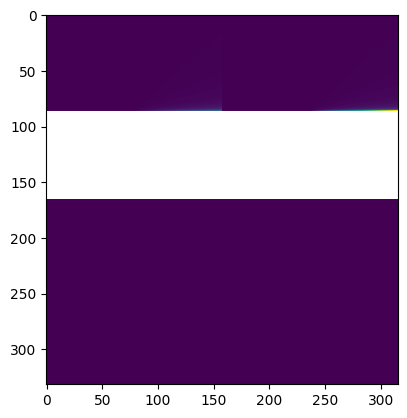

In [135]:
matplotlib.pyplot.imshow(numpy.reshape(coords[:, 0], ds.lon.shape[1:3]))

array([[-3673535.27759488,  4072578.3178713 ],
       [-3678754.97255397,  4131121.03946596],
       [-3683352.48286072,  4190606.58862798],
       ...,
       [-3676406.8397986 ,  4064864.84795611],
       [-3680403.12480536,  4108218.83875479],
       [-3684134.28464062,  4151947.98734783]], shape=(104912, 2))